In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
import pypfopt
#
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [35]:
df_complete = pd.read_csv('../../data/df_monthly_returns_complete.csv', index_col='Date')
df_overview = pd.read_csv('../../data/df_overview.csv', index_col=0)

In [36]:
df_overview[['company_name', 'stock_ticker_symbol' , 'score']].sort_values(by='score', ascending=False)

,company_name,stock_ticker_symbol,score
734,Sony Group Corp.,6758.T,0.929032
456,KEYENCE Corp.,6861.T,0.882153
486,"FAST RETAILING CO., LTD.",9983.T,0.788997
1627,"Daiichi Sankyo Co., Ltd.",4568.T,0.762761
1631,KDDI Corp.,9433.T,0.707565
...,...,...,...
1037,Triton International Ltd.,TRTN.PRE,NaN
1135,National Rural Utilities Cooperative Finance Corp.,NRUC,NaN
1200,Kontron AG,KTN.DE,NaN
1236,BT Group Plc,BT.A.L,NaN


Epoch 0: train RMSE 0.8823, test RMSE 0.8984
Epoch 100: train RMSE 0.1864, test RMSE 0.1435
Epoch 200: train RMSE 0.1842, test RMSE 0.1463
Epoch 300: train RMSE 0.1839, test RMSE 0.1446
Epoch 400: train RMSE 0.1869, test RMSE 0.1440
Epoch 500: train RMSE 0.1844, test RMSE 0.1439
Epoch 600: train RMSE 0.1836, test RMSE 0.1493
Epoch 700: train RMSE 0.1827, test RMSE 0.1446
Epoch 800: train RMSE 0.1839, test RMSE 0.1440
Epoch 900: train RMSE 0.1801, test RMSE 0.1450


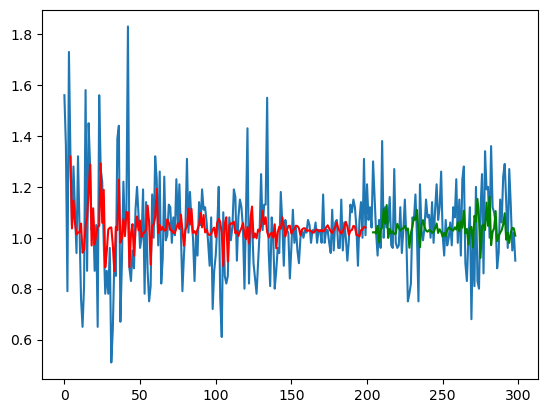

In [37]:
timeseries = df_complete[["NVDA"]].dropna().values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class LSTMBasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = LSTMBasicModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 1000 #2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader: 
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

# shift train predictions for plotting
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

In [86]:
# Create the plot
fig = go.Figure()

# Add the timeseries line
fig.add_trace(go.Scatter(y=np.hstack(timeseries), mode='lines', name='Timeseries',
                         line=dict(color='#5c839f', width=2)))  #, line=dict(color='red'))
# Add the training plot in red
fig.add_trace(go.Scatter(y=np.hstack(train_plot), mode='lines', name='Train Plot',
                         line=dict(color='red', width=2)))  #, line=dict(color='red')
# Add the testing plot in green
fig.add_trace(go.Scatter(y=np.hstack(test_plot), mode='lines', name='Test Plot',
                         line=dict(color='green', width=2)))  # , line=dict(color='green')

# Update layout with labels
fig.update_layout(
    title='Timeseries Plot with Train and Test',
    xaxis_title='Date',
    yaxis_title='Values',
    legend=dict(title="Legend")
)

# Show plot
fig.show()

array([[       nan],
       [       nan],
       [       nan],
       [       nan],
       [1.3189023 ],
       [1.0366207 ],
       [1.1461899 ],
       [1.0583996 ],
       [1.0136609 ],
       [1.0202749 ],
       [1.0214977 ],
       [1.0556867 ],
       [0.9411714 ],
       [0.95329446],
       [1.046431  ],
       [1.0803584 ],
       [1.1804037 ],
       [1.2879525 ],
       [0.9696655 ],
       [1.1157994 ],
       [0.974198  ],
       [1.011436  ],
       [1.0423199 ],
       [1.0473578 ],
       [1.2916794 ],
       [1.0585455 ],
       [1.1881398 ],
       [0.8837344 ],
       [0.9457333 ],
       [1.0325605 ],
       [1.0394065 ],
       [1.040449  ],
       [0.97137016],
       [0.86835283],
       [1.043199  ],
       [1.0298294 ],
       [1.2279742 ],
       [0.98054385],
       [0.99998957],
       [1.0725687 ],
       [1.0062902 ],
       [1.1003042 ],
       [1.1002612 ],
       [0.88408643],
       [1.0154917 ],
       [1.0534416 ],
       [0.9291523 ],
       [1.028